## Data set pruning and plotting


1.
Reported cases data

Get county level reported cases data for each county in our  analysis.

Smooth the  data  and apply restrictions:


final data panel
```
fips, date, cumulative_cases, smoothed_cumulative_cases, county, state
```

2.
Also have table for paper showing
```
state, county, user panel size, reported cases data used
```
this is created by joining (1) with fuller table that includes FIPS
```
fips, user panel size
```

In [141]:
import datetime
import math
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from IPython.display import clear_output

datapath = '/data/covid/'
metro_area_to_id = {
    'NY':35620,
    'Seattle':42660,
    'Dallas':19100,
    'Washington':47900,
    'Houston':26420,
    'Chicago':16980,
    'Miami':33100,
    'LA':31080,
    'Boston':14460,
    'San Francisco':41860,
    'Philadelphia':37980,
}
use_metros = [
    'Dallas',
    'Seattle',
    'Washington',
    'NY',
    'Miami',
    'Boston',
    'LA',
]

DATE = 'date'
FIPS = 'fips'
GEOID  = 'GEOID'


date_fmt = '%Y-%m-%d'


%config InlineBackend.figure_format = 'retina'

###  Reported cases data for counties

In [107]:
counties_cases_data_url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

counties_cases_df = pd.read_csv(counties_cases_data_url,
                     usecols=[0,1,2,3,4],
                     parse_dates=[DATE],
                     squeeze=True).sort_index()

counties_cases_df.sort_values(DATE, ascending=False).head(3)

,date,county,state,fips,cases
206592,2020-06-04,Weston,Wyoming,56045.0,1
204588,2020-06-04,Gallatin,Kentucky,21077.0,46
204597,2020-06-04,Harlan,Kentucky,21095.0,4


get the county FIPs for each metro area  from the user panel

In [108]:
metro_areas_names_fpaths = {m:'{}{}/'.format(datapath,m_id) for m,m_id in metro_area_to_id.items()}
metro_areas_names_fpaths

{'Boston': '/data/covid/14460/',
 'Chicago': '/data/covid/16980/',
 'Dallas': '/data/covid/19100/',
 'Houston': '/data/covid/26420/',
 'LA': '/data/covid/31080/',
 'Miami': '/data/covid/33100/',
 'NY': '/data/covid/35620/',
 'Philadelphia': '/data/covid/37980/',
 'San Francisco': '/data/covid/41860/',
 'Seattle': '/data/covid/42660/',
 'Washington': '/data/covid/47900/'}

In [203]:
# We save the RT data to '/data/covid/AREA/AREA_cases_rt.csv'
county_cases_fnames = {m: '{}{}_counties_cases.csv'.format(fpath, metro_area_to_id[m]) for m, fpath in metro_areas_names_fpaths.items()}
county_cases_fnames

{'Boston': '/data/covid/14460/14460_counties_cases.csv',
 'Chicago': '/data/covid/16980/16980_counties_cases.csv',
 'Dallas': '/data/covid/19100/19100_counties_cases.csv',
 'Houston': '/data/covid/26420/26420_counties_cases.csv',
 'LA': '/data/covid/31080/31080_counties_cases.csv',
 'Miami': '/data/covid/33100/33100_counties_cases.csv',
 'NY': '/data/covid/35620/35620_counties_cases.csv',
 'Philadelphia': '/data/covid/37980/37980_counties_cases.csv',
 'San Francisco': '/data/covid/41860/41860_counties_cases.csv',
 'Seattle': '/data/covid/42660/42660_counties_cases.csv',
 'Washington': '/data/covid/47900/47900_counties_cases.csv'}

In [110]:
# get the counties for each  metro area by the unique counties from user panel

def geoid_to_county_id(geoid):
    return str(geoid)[:5]

def get_county_fips(metro_area_fpath):
    homes_fpath = metro_area_fpath+'homes.final.txt'
    data_panel_df = pd.read_csv(homes_fpath, dtype={GEOID:'str'}) # do not read GEOID in as int because it strips off leading zero
    return list(data_panel_df[GEOID].apply(geoid_to_county_id).unique())
    

In [111]:
metro_areas_county_fips = {}

for name, fpath in metro_areas_names_fpaths.items():
    if name not in use_metros:
        continue
    print('getting counties for metro area: %s'% name)
    try:
        fips = get_county_fips(fpath)
        metro_areas_county_fips[name] = fips
    except Exception as e:
        print('error getting county data for %s' % name)
        print(e)

getting counties for metro area: LA
getting counties for metro area: Miami
getting counties for metro area: Boston
getting counties for metro area: Washington
getting counties for metro area: Dallas
getting counties for metro area: NY
getting counties for metro area: Seattle


In [112]:
# Handle that the NY Times data source combines the New York City counties data

NYC = 'New York City'
NYC_FIPS = '99999'

metro_areas_county_fips['NY'] = metro_areas_county_fips['NY'] + [NYC_FIPS]

counties_cases_df.loc[(counties_cases_df['county'] == NYC), FIPS] = NYC_FIPS
counties_cases_df[counties_cases_df['county'] == NYC].head()

,date,county,state,fips,cases
416,2020-03-01,New York City,New York,99999,1
448,2020-03-02,New York City,New York,99999,1
482,2020-03-03,New York City,New York,99999,2
518,2020-03-04,New York City,New York,99999,2
565,2020-03-05,New York City,New York,99999,4


In [113]:
def fips_str(fips):
    try:
        return str(int(float(fips))).zfill(5)
    except:
        return fips

assert(fips_str('06059') == '06059')
assert(fips_str(NYC_FIPS) == NYC_FIPS)

In [114]:
counties_cases_df[FIPS] = counties_cases_df[FIPS].apply(fips_str)
counties_cases_df = counties_cases_df.set_index(['county', DATE]).sort_index()

In [115]:
counties_cases_df.head()

state   fips  cases
county    date                                    
Abbeville 2020-03-19  South Carolina  45001      1
          2020-03-20  South Carolina  45001      1
          2020-03-21  South Carolina  45001      1
          2020-03-22  South Carolina  45001      1
          2020-03-23  South Carolina  45001      1

In [116]:
print(counties_cases_df.shape)

print('%s counties'  % counties_cases_df[FIPS].nunique())

(206593, 3)
2978 counties


In [117]:
# limit the data to our  FIPs
counties_fips = []
for fips_list in metro_areas_county_fips.values():
    counties_fips += fips_list

In [118]:

counties_cases_df = counties_cases_df[counties_cases_df[FIPS].isin(counties_fips)]

print(counties_cases_df.shape)
print('%s counties'  % counties_cases_df['fips'].nunique())

counties_cases_df.head()

(6016, 3)
71 counties


state   fips  cases
county          date                              
Alexandria city 2020-03-12  Virginia  51510      1
                2020-03-13  Virginia  51510      1
                2020-03-14  Virginia  51510      1
                2020-03-15  Virginia  51510      1
                2020-03-16  Virginia  51510      2

restrict data to:
- start after at least 10 cumulative cases
- county must have at least 31 days of data and at least 100 cumulative cases as of May 31
    

In [206]:
def plot_cases_data(data, ax, title):
    ax.set_title(title)
    cases = data['cases']
    index=data.index.get_level_values('date')
    ax.plot(
        index,
        cases.values,
        c='k',
        linestyle=':',
        alpha=.5,
        label='Actual')
    smoothed_cases = data[SMOOTHED_CASES]
    ax.plot(index,
            smoothed_cases,
            label='Smoothed')

    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    # ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.set_xlim(pd.Timestamp('2020-03-01'), data.index.get_level_values(DATE)[-1]+pd.Timedelta(days=1))
    ax.get_figure().set_facecolor('w')
    
    ax.legend()
    

,cases,smoothed_cases
date,,
2020-03-07,12,12.0
2020-03-08,14,19.0
2020-03-09,20,30.0
2020-03-10,37,48.0
2020-03-11,52,79.0


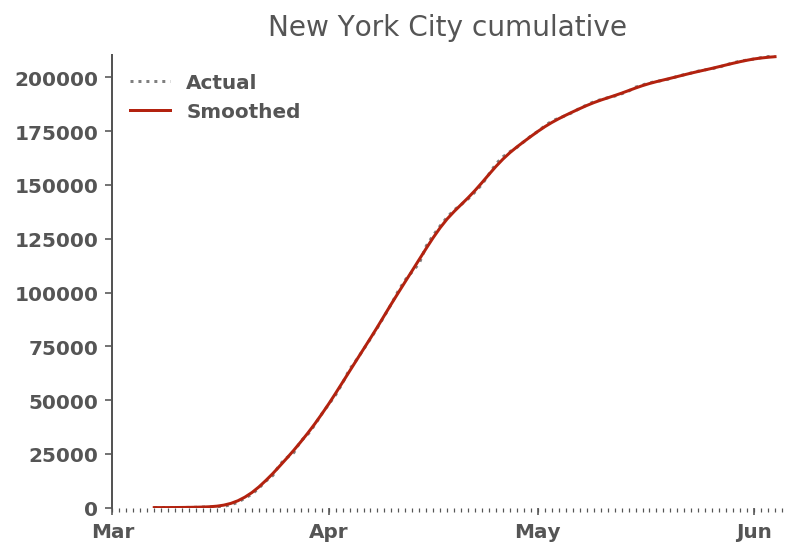

In [207]:
SMOOTHED_CASES = 'smoothed_cases'
county = NYC #'34017' #'99999' # NYC

def prepare_cases(cases, cutoff=10):

    smoothed_cases = cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    # only include data after cutoff total cases
    idx_start = np.searchsorted(cases, cutoff)
    
    cases = cases.iloc[idx_start:]
    smoothed_cases = smoothed_cases.iloc[idx_start:].rename(SMOOTHED_CASES)
    return cases, smoothed_cases

all_cases = counties_cases_df.xs(county)['cases']
cases, smoothed_cases = prepare_cases(all_cases)
data = pd.concat([cases, smoothed_cases], axis=1)
title="%s cumulative" % county

figure,ax = plt.subplots()
plot_cases_data(data, ax, title)
data.head()

In [142]:
metro_area_county_dfs = {}

for metro_area, county_fips in metro_areas_county_fips.items():
    metro_counties_cases_df = counties_cases_df[counties_cases_df[FIPS].isin(county_fips)]
    
    # index by FIPS, date
    # important to use FIPs because County name repeats across States, and sometimes  within same metro area
    # e.g. there is a Lake IL and Lake IN, both in Chicago metro area
    metro_counties_cases_df = metro_counties_cases_df.sort_values(FIPS).reset_index().set_index([FIPS,DATE]).sort_index()
    
    county_dfs = {}

    counties_to_process = metro_counties_cases_df
    grouped_counties_to_process = metro_counties_cases_df.groupby(level=FIPS)

    for i, (fips, data) in enumerate(grouped_counties_to_process):
        clear_output(wait=True)
        name = data['county'][-1]
        print('%s/%s Processing %s in %s (FIPS: %s)' % (str(i+1), len(grouped_counties_to_process), name, metro_area, fips))
        
        cases, smoothed_cases = prepare_cases(data['cases'], cutoff=25)

        result = pd.concat([cases, smoothed_cases], axis=1)
        result['county'] = data['county'][-1]
        result['state'] = data['state'][-1]
        county_dfs[fips] = result.droplevel(0)[1:]
        
    metro_area_county_dfs[metro_area] = county_dfs
    print('Done with %s' % metro_area)

metro_area_county_dfs  



3/3 Processing Snohomish in Seattle (FIPS: 53061)
Done with Seattle


{'Boston': {'25009':             cases  smoothed_cases county          state
  date                                                   
  2020-03-21     41            47.0  Essex  Massachusetts
  2020-03-22     60            68.0  Essex  Massachusetts
  2020-03-23     73            98.0  Essex  Massachusetts
  2020-03-24    118           141.0  Essex  Massachusetts
  2020-03-25    177           201.0  Essex  Massachusetts
  2020-03-26    247           276.0  Essex  Massachusetts
  2020-03-27    350           365.0  Essex  Massachusetts
  2020-03-28    472           463.0  Essex  Massachusetts
  2020-03-29    570           566.0  Essex  Massachusetts
  2020-03-30    653           675.0  Essex  Massachusetts
  2020-03-31    784           794.0  Essex  Massachusetts
  2020-04-01    885           925.0  Essex  Massachusetts
  2020-04-02   1039          1067.0  Essex  Massachusetts
  2020-04-03   1238          1217.0  Essex  Massachusetts
  2020-04-04   1400          1370.0  Essex  Massachus

In [197]:
# determine whether county has sufficient data
# county must have at least 31 days of data and at least 100 cumulative cases as of May 31

SUFFICIENT_DATA_DAY_CHECK = '2020-05-31' # May 31 2020
SUFFICIENT_CASES = 100
SUFFICIENT_DAYS = 30

filtered_metro_area_county_dfs  = {}

for metro_area, county_data in metro_area_county_dfs.items():
    dfs = {}
    print('handling {} counties for {} counties\n'.format(len(county_data),metro_area))
    for i, (fips, data) in enumerate(county_data.items()):
        # print('%s: %s' % (i+1, fips))
        # get data  up  to  data day  check
        sufficient = False
        if len(data) >= SUFFICIENT_DAYS:
            check_d = data.reset_index()
            check_d = check_d[check_d[DATE] <= SUFFICIENT_DATA_DAY_CHECK]
            check_cases = check_d.iloc[-1]['cases']
            sufficient = ((check_cases >= SUFFICIENT_CASES) and (len(check_d) >= SUFFICIENT_DAYS))
        if not sufficient:
            print('insufficient data for county %s (%s). Filtering out'  % (fips, metro_area))
            continue
        dfs[fips] = data
            
    filtered_metro_area_county_dfs[metro_area]= dfs

handling 2 counties for LA counties

handling 3 counties for Miami counties

handling 7 counties for Boston counties

handling 12 counties for Dallas counties

insufficient data for county 48497 (Dallas). Filtering out
insufficient data for county 48221 (Dallas). Filtering out
insufficient data for county 48231 (Dallas). Filtering out
insufficient data for county 48367 (Dallas). Filtering out
handling 24 counties for Washington counties

insufficient data for county 51043 (Washington). Filtering out
insufficient data for county 51157 (Washington). Filtering out
insufficient data for county 51610 (Washington). Filtering out
insufficient data for county 51600 (Washington). Filtering out
handling 20 counties for NY counties

handling 3 counties for Seattle counties



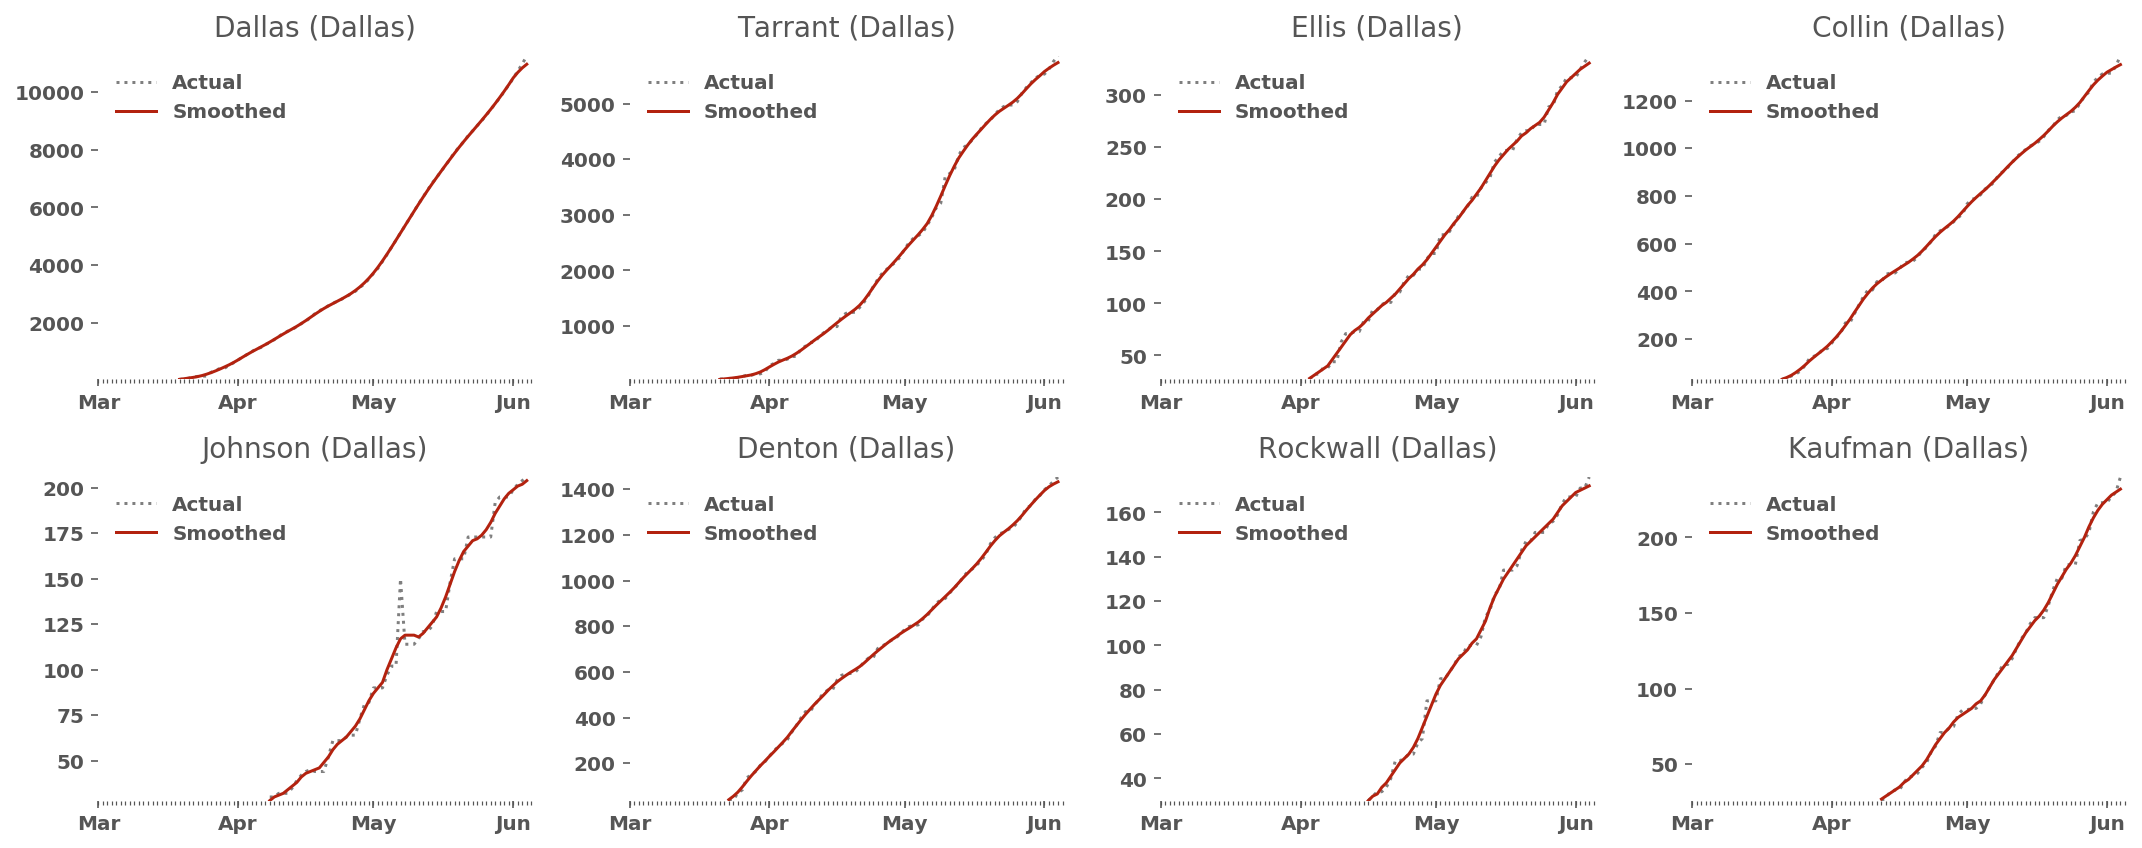

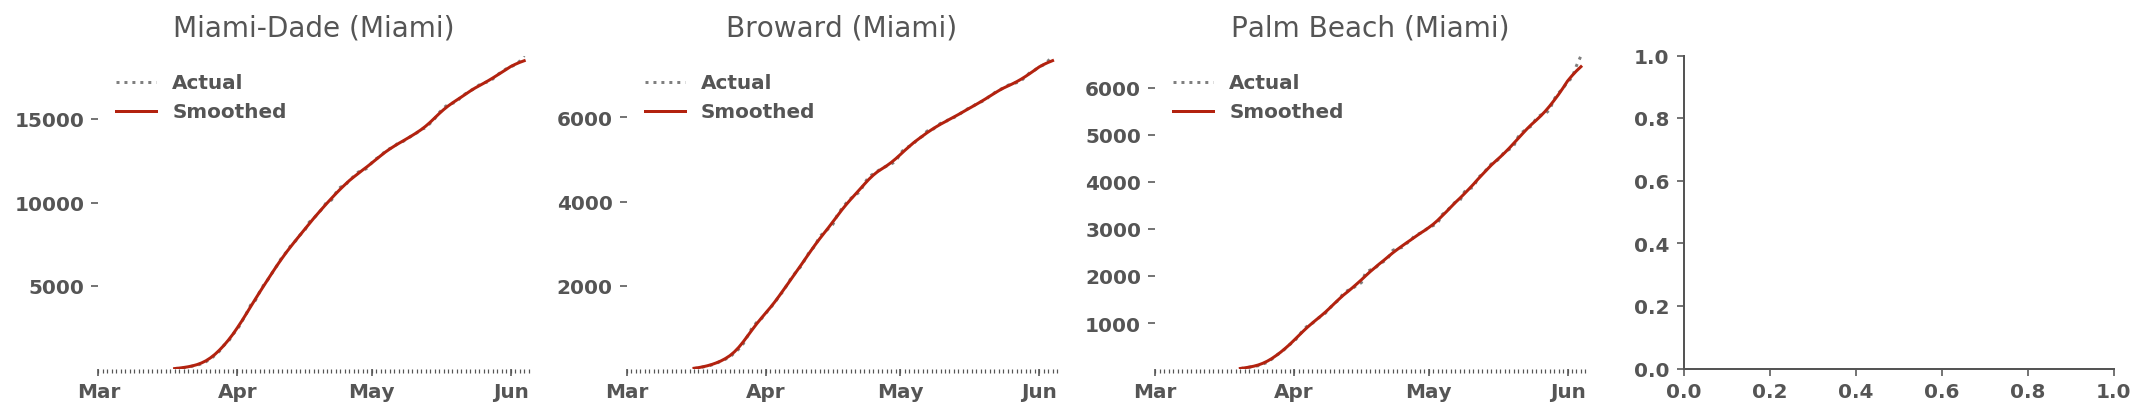

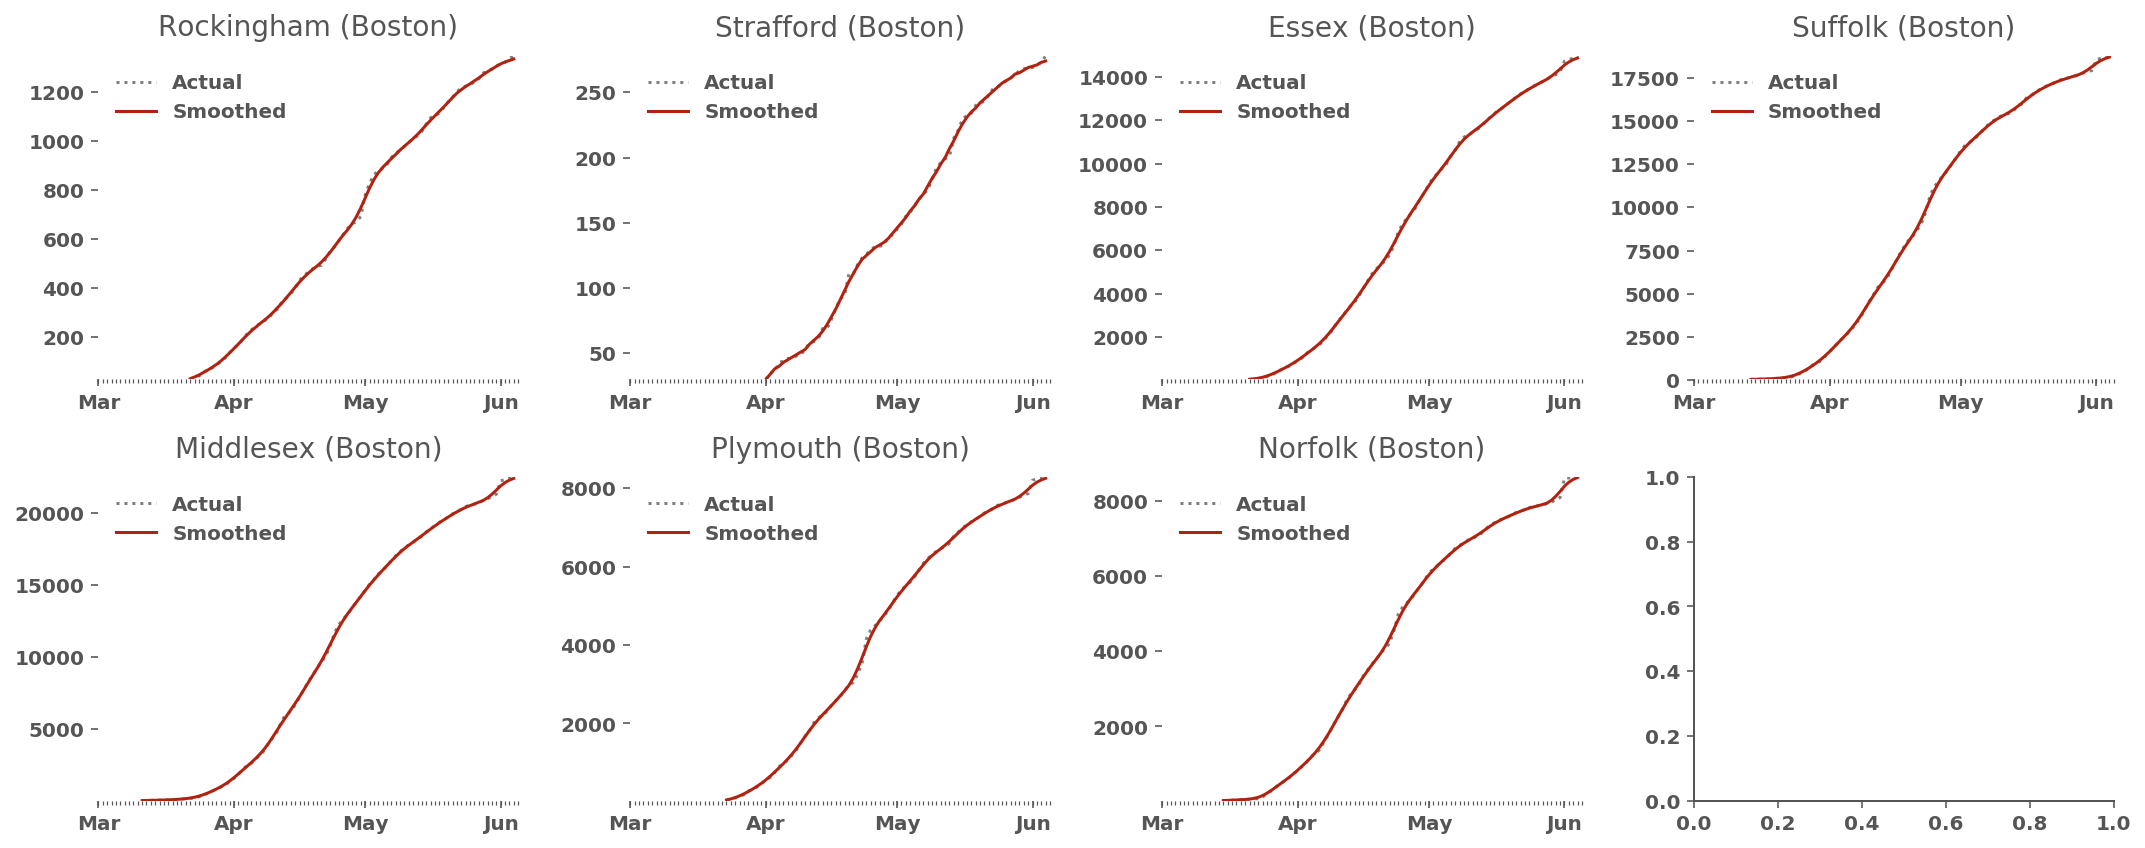

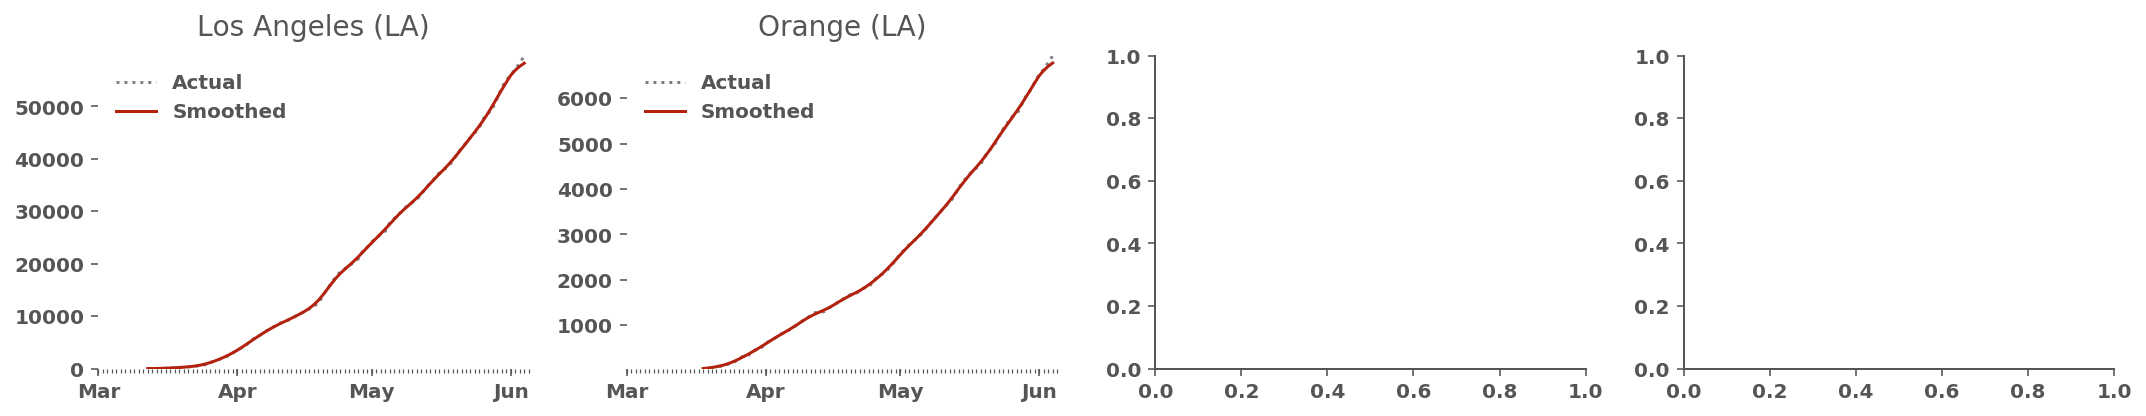

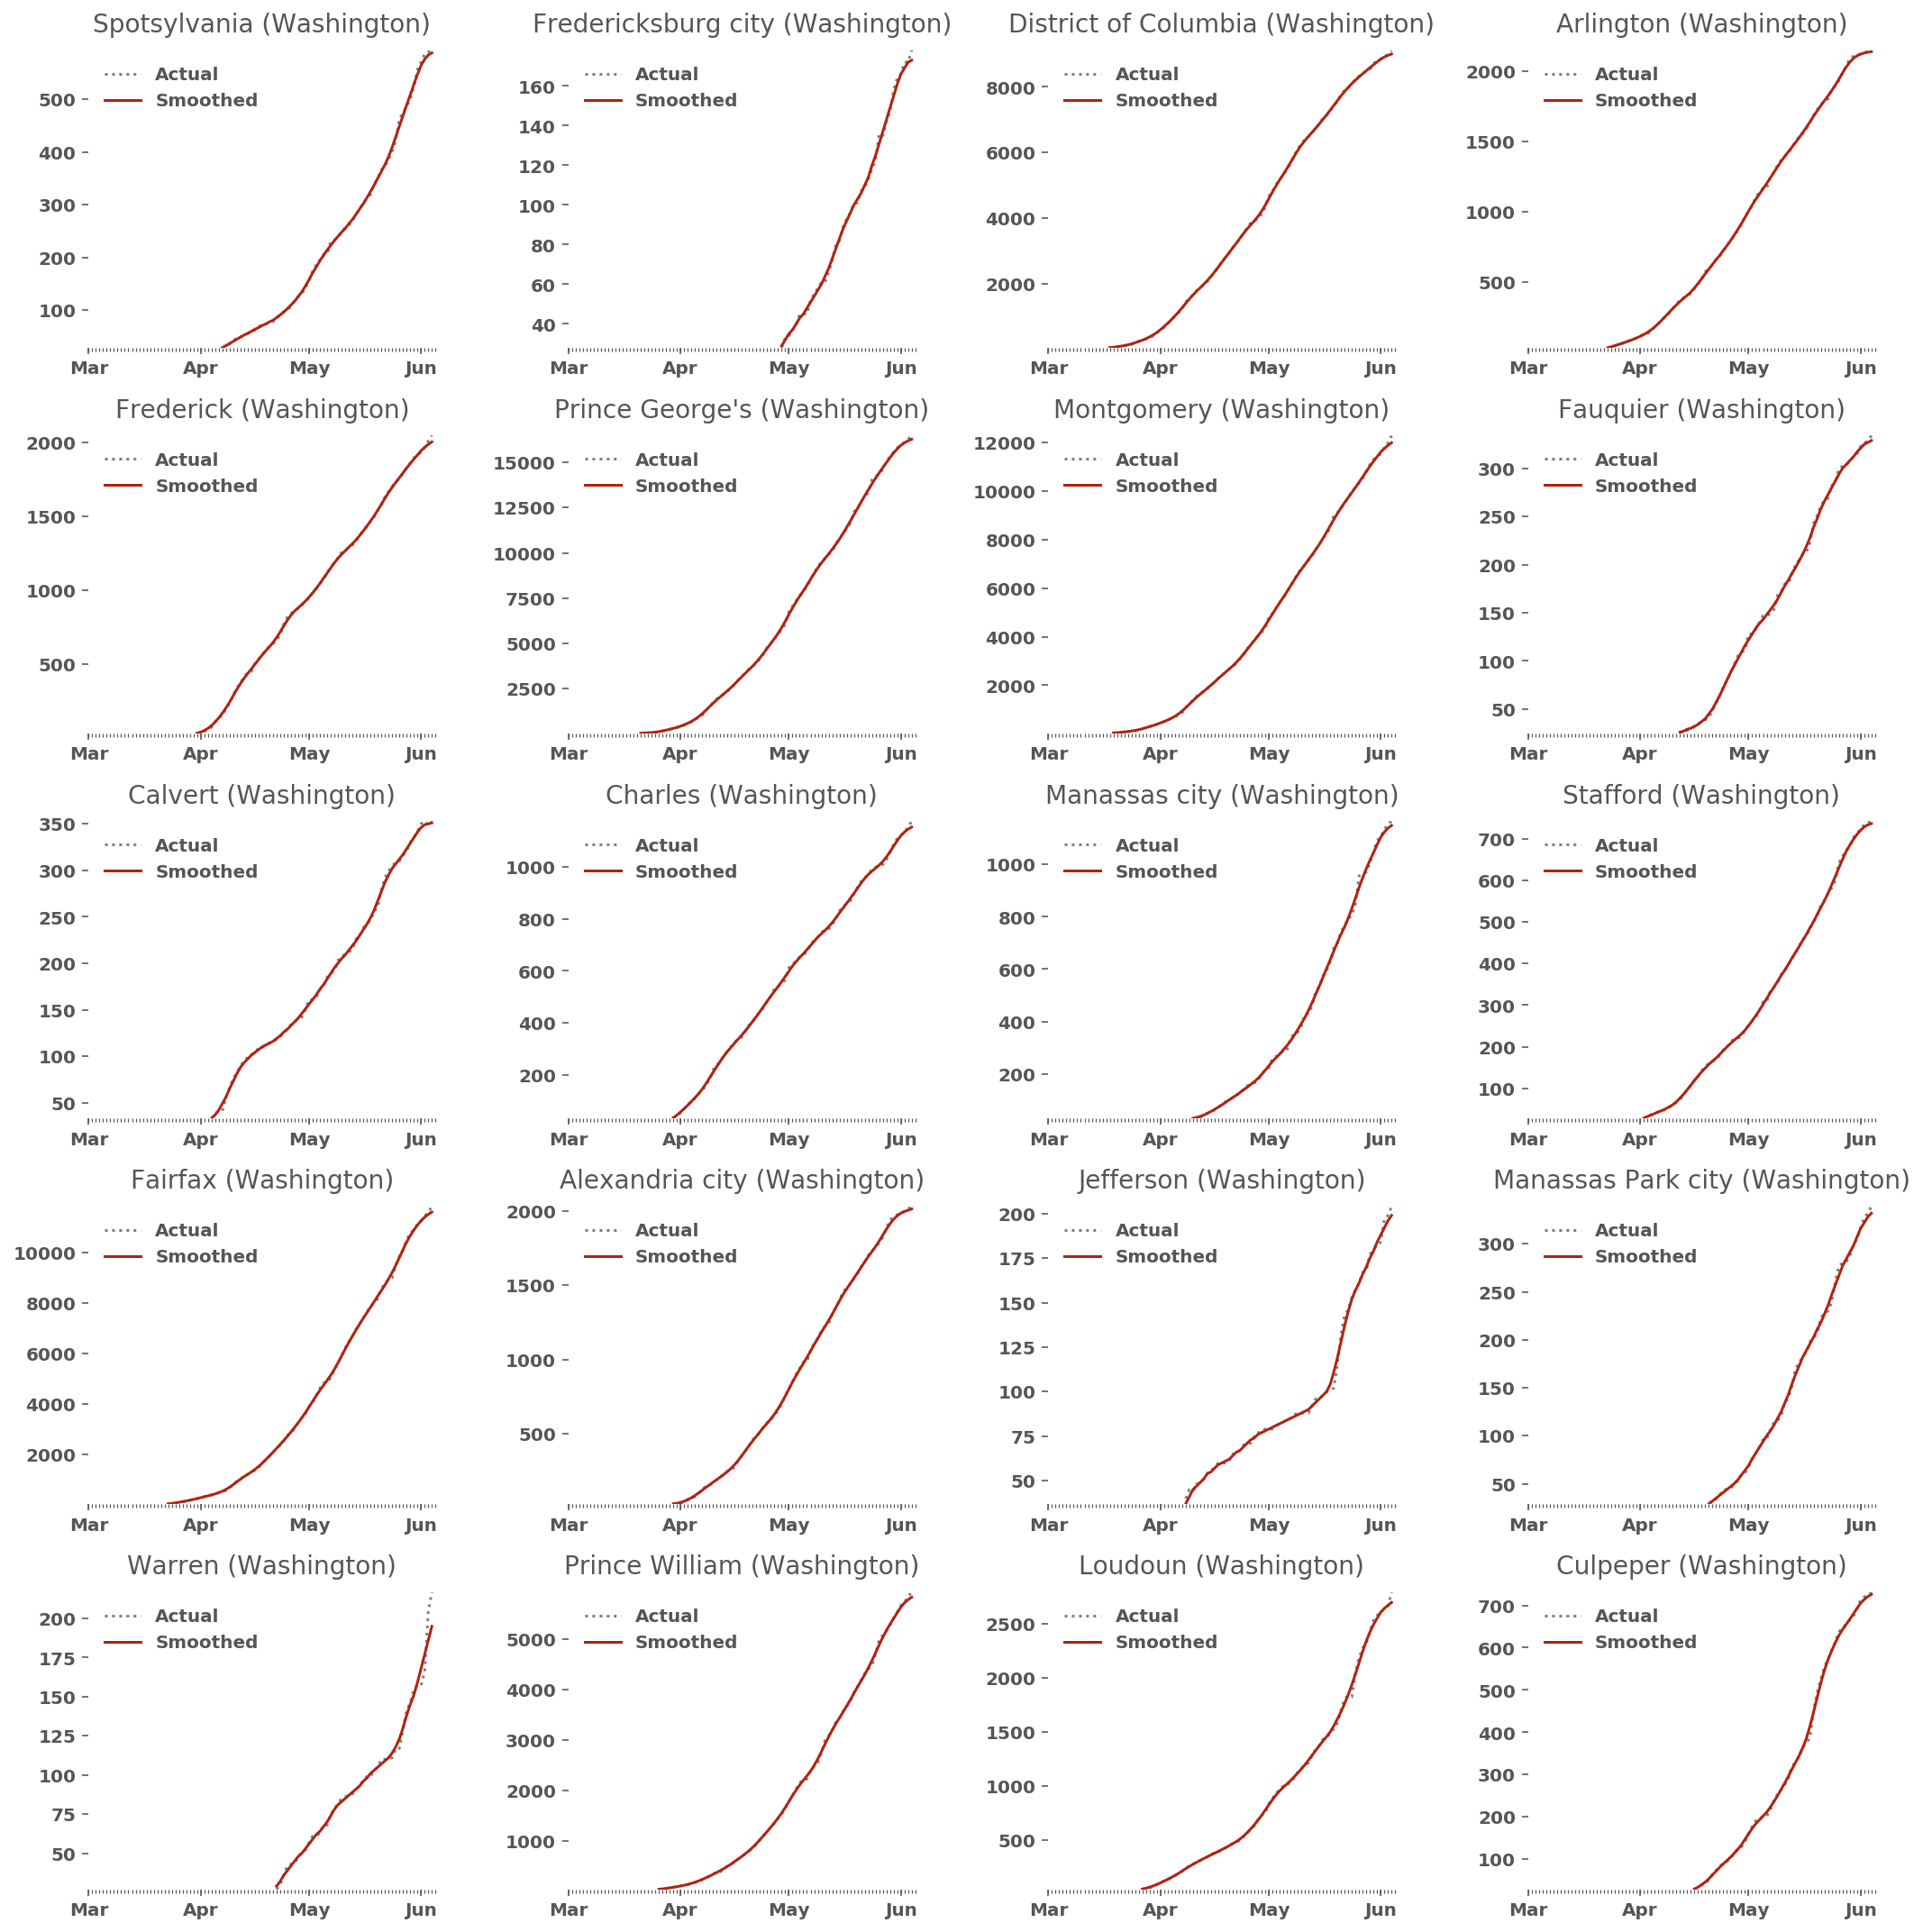

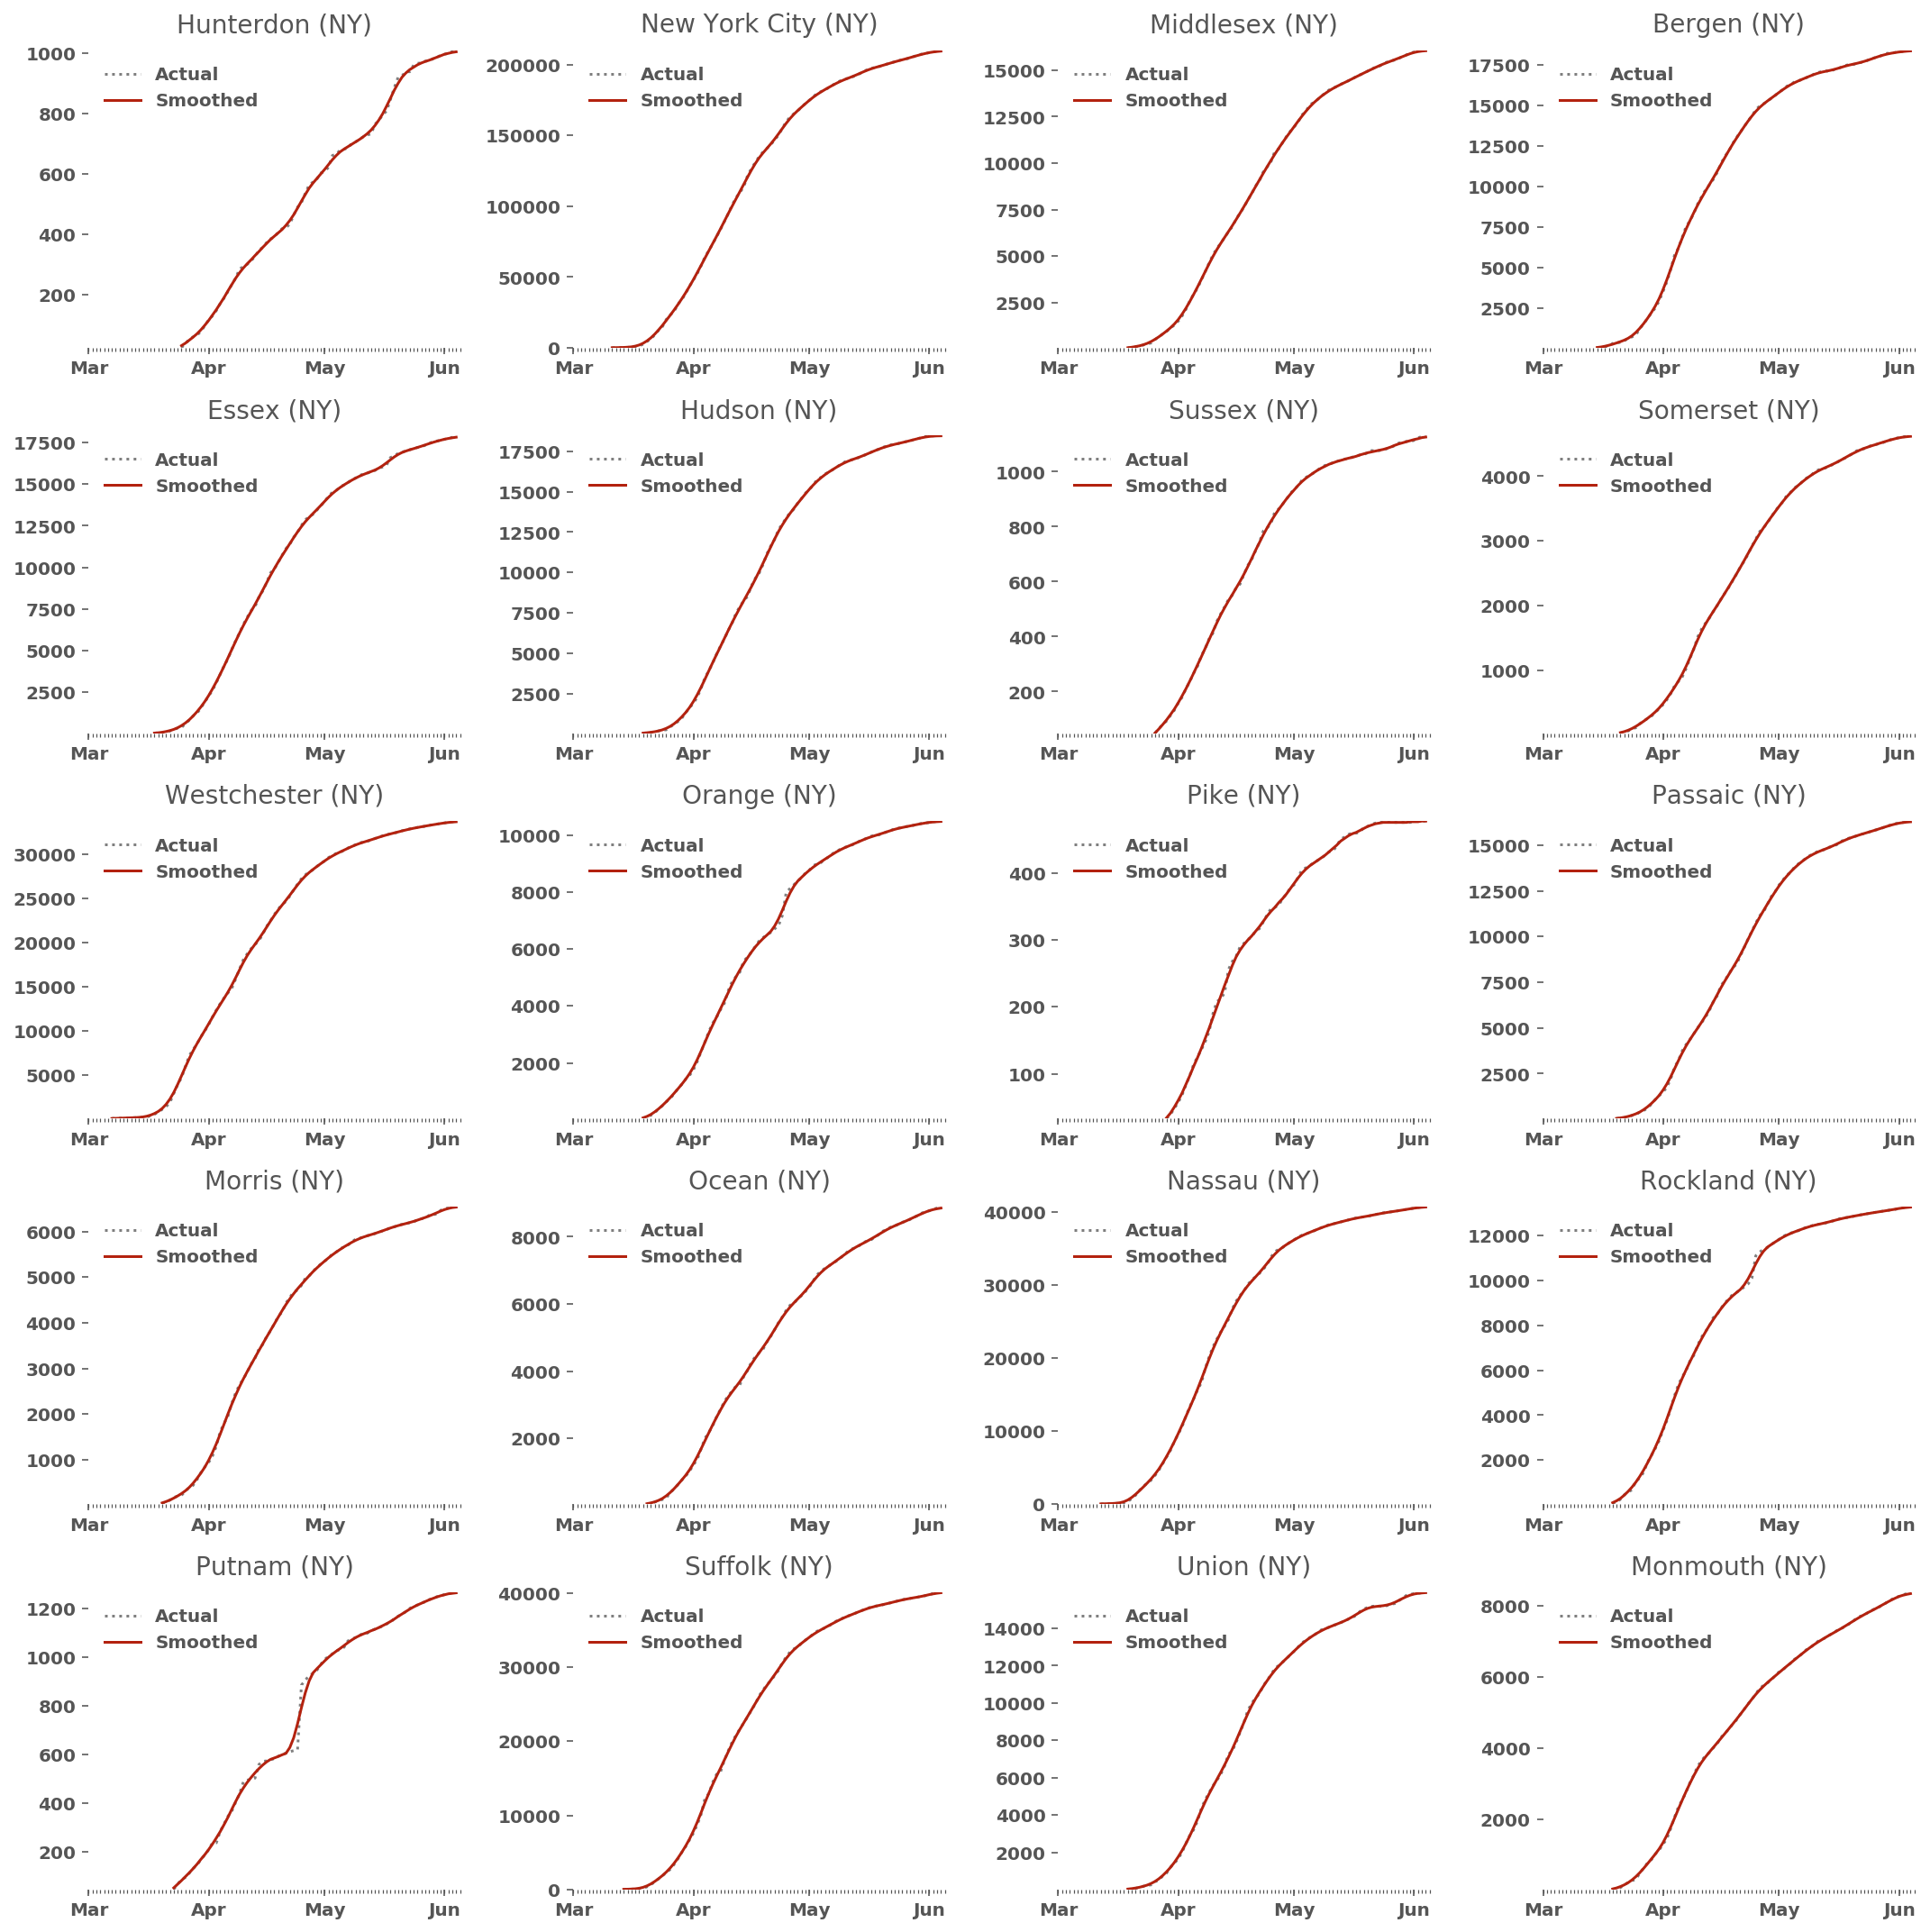

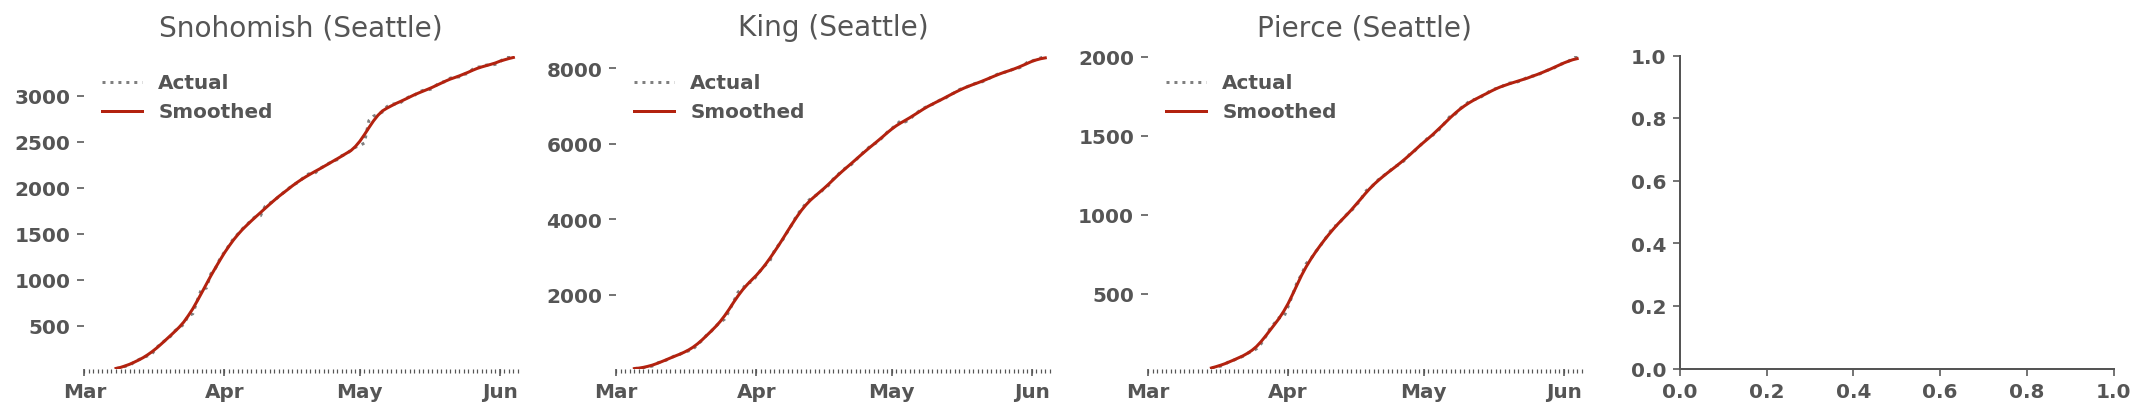

In [205]:
# plot results

# for metro_area, county_data in metro_area_county_dfs.items():
for metro_area, county_data in filtered_metro_area_county_dfs.items():
    # print('\n{} counties\n'.format(metro_area)
    ncols = 4
    nrows = int(np.ceil(float(len(county_data)) / float(ncols)))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

    for i, (fips, data) in enumerate(county_data.items()):
        name = data['county'][-1]
        
        cumulative_cases = data.iloc[-1]['cases']
        plot_title = '%s (%s)' % (name, metro_area)
        plot_cases_data(data, axes.flat[i], plot_title)

    fig.tight_layout()
    fig.set_facecolor('w')
    plt.show()


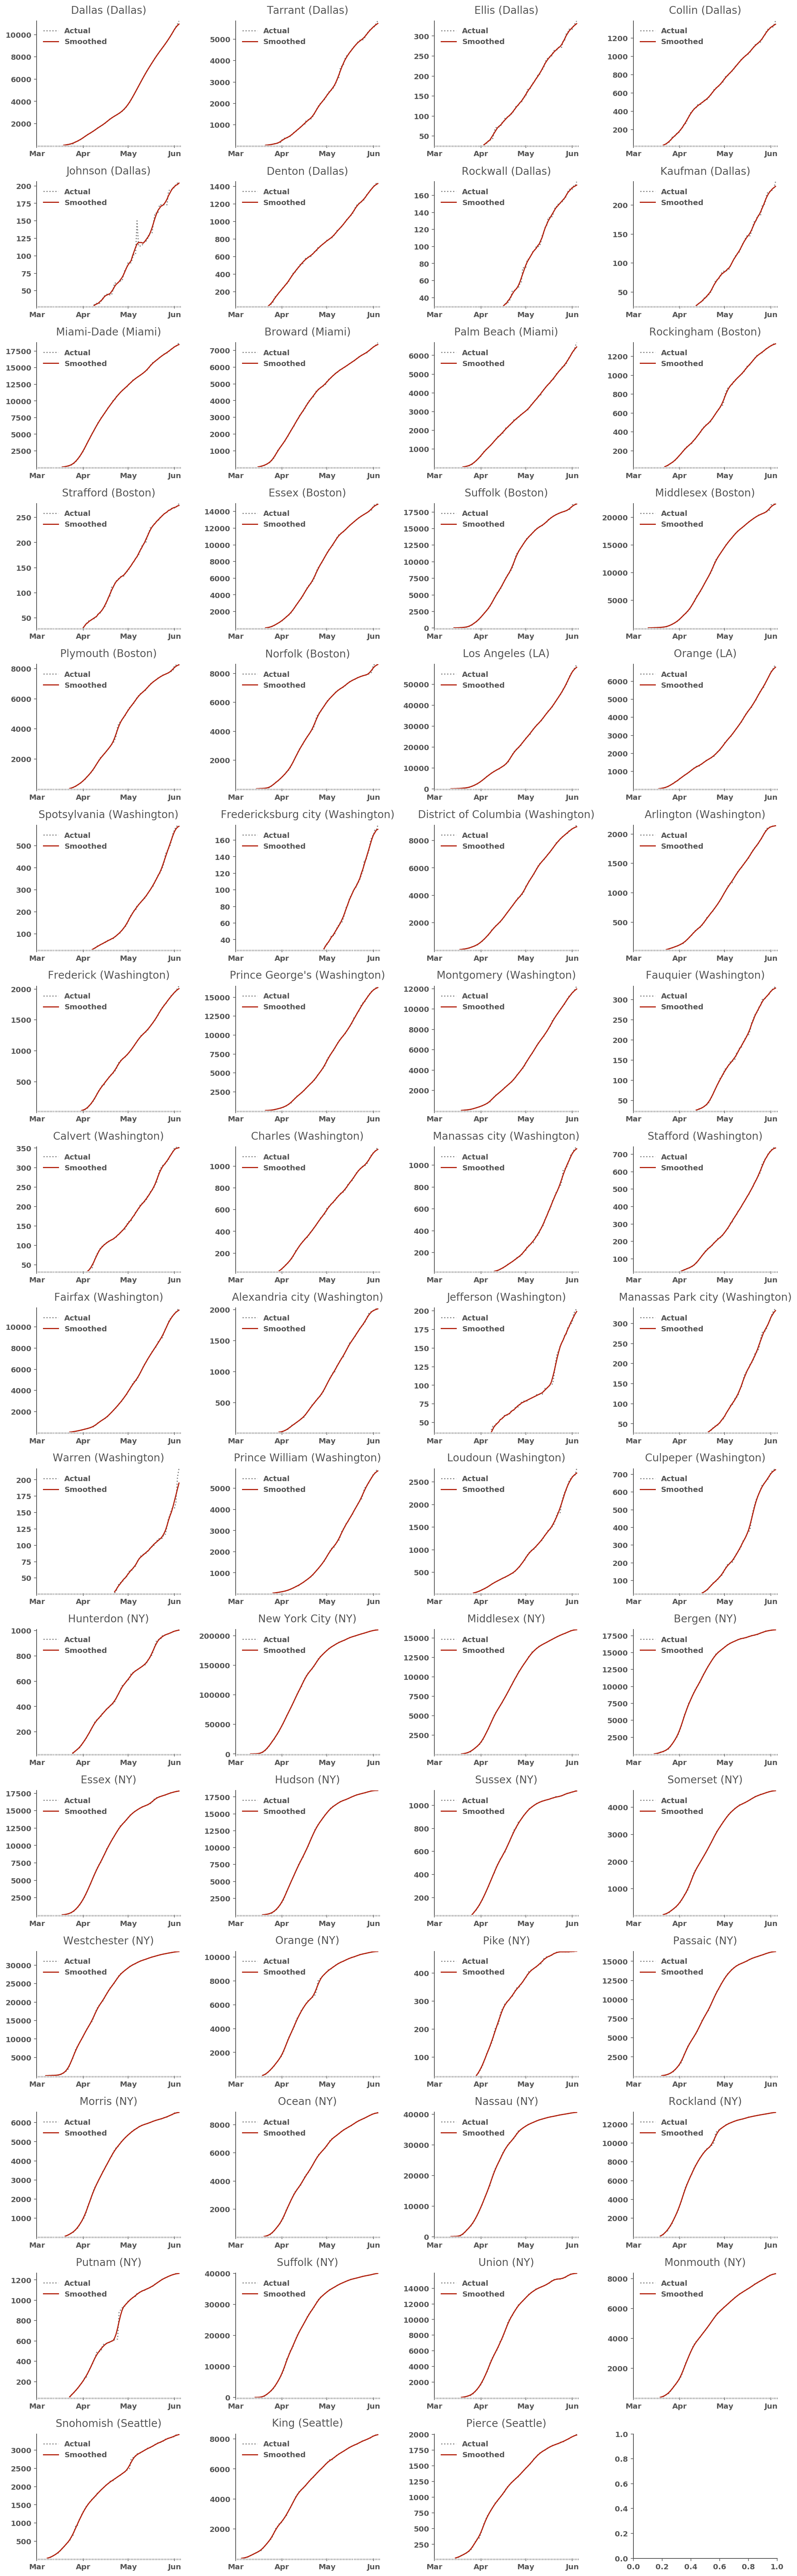

In [211]:
# plot without empty plots

filtered_counties_count = 0
for m, d in filtered_metro_area_county_dfs.items():
    filtered_counties_count += len(d)
ncols=4
nrows = int(np.ceil(float(filtered_counties_count)/float(ncols)))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
i = 0
for metro_area, county_data in filtered_metro_area_county_dfs.items():
    for fips, data in county_data.items():
        name = data['county'][-1]
        cumulative_cases = data.iloc[-1]['cases']
        plot_title = '%s (%s)' % (name, metro_area)
        plot_cases_data(data, axes.flat[i], plot_title)
        i += 1

fig.tight_layout()
fig.set_facecolor('w')
plt.show()

In [204]:
# Export the  data to CSV

for metro_area, county_data in filtered_metro_area_county_dfs.items():
    if not len(county_data):
        print('no results for %s. skipping.' % metro_area)
        continue
    counties_cases_fname = county_cases_fnames[metro_area]
    print('saving cases data for {} to file: {}'.format(metro_area, counties_cases_fname))
    counties_cases = None

    for fips, data in county_data.items():
        r = data.copy()
        r.index = pd.MultiIndex.from_product([[fips], data.index], names=[FIPS, DATE])
        if counties_cases is None:
            counties_cases = r
        else:
            counties_cases = pd.concat([counties_cases, r])

    counties_cases.sort_index(inplace=True)

    counties_cases.to_csv(counties_cases_fname)
    print('saved.')
counties_cases

saving cases data for Dallas to file: /data/covid/19100/19100_counties_cases.csv
saved.
saving cases data for Miami to file: /data/covid/33100/33100_counties_cases.csv
saved.
saving cases data for Boston to file: /data/covid/14460/14460_counties_cases.csv
saved.
saving cases data for LA to file: /data/covid/31080/31080_counties_cases.csv
saved.
saving cases data for Washington to file: /data/covid/47900/47900_counties_cases.csv
saved.
saving cases data for NY to file: /data/covid/35620/35620_counties_cases.csv
saved.
saving cases data for Seattle to file: /data/covid/42660/42660_counties_cases.csv
saved.


cases  smoothed_cases     county       state
fips  date                                                    
53033 2020-03-05     52            49.0       King  Washington
      2020-03-06     59            62.0       King  Washington
      2020-03-07     72            82.0       King  Washington
      2020-03-08     91           109.0       King  Washington
      2020-03-09    117           142.0       King  Washington
      2020-03-10    191           184.0       King  Washington
      2020-03-11    235           231.0       King  Washington
      2020-03-12    271           280.0       King  Washington
      2020-03-13    329           331.0       King  Washington
      2020-03-14    389           380.0       King  Washington
      2020-03-15    421           428.0       King  Washington
      2020-03-16    489           481.0       King  Washington
      2020-03-17    518           542.0       King  Washington
      2020-03-18    563           616.0       King  Washington
      2020-03-19    693           706.0       King  Washington
      2020-03-20    794           810.0       King  Washington
      2020-03-21    935           924.0       King  Washington
      2020-03-22   1036          1040.0       King  Washington
      2020-03-23   1166          1161.0       King  Washington
      2020-03-24   1278          1295.0       King  Washington
      2020-03-25   1360          1450.0       King  Washington
      2020-03-26   1579          1623.0       King  Washington
      2020-03-27   1830          1808.0       King  Washington
      2020-03-28   2079          1982.0       King  Washington
      2020-03-29   2163          2140.0       King  Washington
      2020-03-30   2332          2276.0       King  Washington
      2020-03-31   2332          2399.0       King  Washington
      2020-04-01   2498          2518.0       King  Washington
      2020-04-02   2658          2654.0       King  Washington
      2020-04-03   2789          2803.0       King  Washington
...                 ...             ...        ...         ...
53061 2020-05-06   2830          2842.0  Snohomish  Washington
      2020-05-07   2889          2872.0  Snohomish  Washington
      2020-05-08   2917          2898.0  Snohomish  Washington
      2020-05-09   2917          2923.0  Snohomish  Washington
      2020-05-10   2932          2945.0  Snohomish  Washington
      2020-05-11   2970          2968.0  Snohomish  Washington
      2020-05-12   2998          2992.0  Snohomish  Washington
      2020-05-13   3009          3016.0  Snohomish  Washington
      2020-05-14   3048          3037.0  Snohomish  Washington
      2020-05-15   3065          3057.0  Snohomish  Washington
      2020-05-16   3071          3077.0  Snohomish  Washington
      2020-05-17   3082          3098.0  Snohomish  Washington
      2020-05-18   3125          3121.0  Snohomish  Washington
      2020-05-19   3153          3144.0  Snohomish  Washington
      2020-05-20   3162          3167.0  Snohomish  Washington
      2020-05-21   3198          3188.0  Snohomish  Washington
      2020-05-22   3212          3205.0  Snohomish  Washington
      2020-05-23   3212          3223.0  Snohomish  Washington
      2020-05-24   3240          3243.0  Snohomish  Washington
      2020-05-25   3249          3263.0  Snohomish  Washington
      2020-05-26   3297          3285.0  Snohomish  Washington
      2020-05-27   3318          3305.0  Snohomish  Washington
      2020-05-28   3323          3321.0  Snohomish  Washington
      2020-05-29   3341          3335.0  Snohomish  Washington
      2020-05-30   3341          3349.0  Snohomish  Washington
      2020-05-31   3349          3364.0  Snohomish  Washington
      2020-06-01   3379          3383.0  Snohomish  Washington
      2020-06-02   3412          3398.0  Snohomish  Washington
      2020-06-03   3427          3412.0  Snohomish  Washington
      2020-06-04   3442          3424.0  Snohomish  Washington

[263 rows x 4 columns]